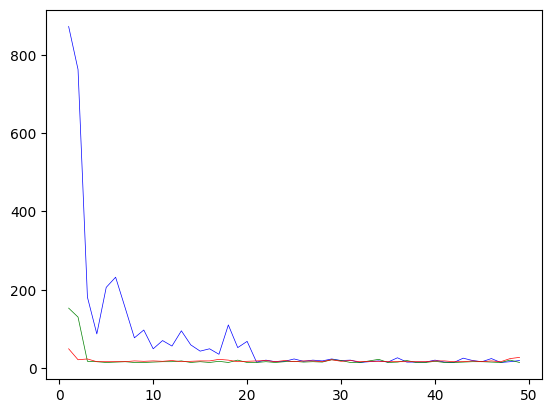

In [106]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

class Maze:
    def __init__(self) -> None:
        self.height = 6
        self.width = 9
        self.obstacles = {
            (2,2),
            (3,2),
            (4,2),
            (1,5),
            (3,7),
            (4,7),
            (5,7),
        }
        self.start = (3,0)
        self.target = (5,8)
        self.pos = self.start

    def state_shape(self):
        return (self.height, self.width)
    
    def action_shape(self):
        return 4
    
    def reset(self):
        self.pos = self.start
        return self.pos
    
    def step(self, action):
        '''if self.pos == self.target:
            self.pos = self.start
            return True, 0, self.pos'''
        
        y = self.pos[0]
        x = self.pos[1]
        match action:
            case 0:#up
                y = min(y + 1, self.height - 1)
            case 1:#down
                y = max(y - 1, 0)
            case 2:#right
                x = min(x + 1, self.width - 1)
            case 3:#left
                x = max(x - 1, 0)
        if (y,x) not in self.obstacles:
            self.pos = (y,x)
        terminated, reward = (True, 1) if self.pos == self.target else (False, 0)
        return terminated, reward, self.pos


class Model:
    def __init__(self) -> None:
        self.model = {}

    def update(self, state, action, reward, next_state):
        if state not in self.model:
            self.model[state] = {}
        self.model[state][action] = (reward, next_state)

    def sample(self):
        state = random.sample(list(self.model.keys()),1)[0]
        action = random.sample(list(self.model[state]),1)[0]
        reward, next_state = self.model[state][action]
        return state, action, reward, next_state


def epsilon_greedy(qs, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        ismaxs = qs.max() == qs
        indices = [i for i in range(len(qs)) if ismaxs[i]]
        return np.random.choice(indices)#slow
        #return qs.argmax()
    

def dyna_q(env, num_episodes, planning_steps, alpha = 0.1, epsilon = 0.1, gamma = 0.95):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    model = Model()
    step_stat = np.zeros(num_episodes,dtype=int)
    for episode in range(num_episodes):
        steps = 0
        state = env.reset()
        while True:
            steps += 1
            action = epsilon_greedy(qs[state], epsilon)
            terminated, reward, next_state = env.step(action)
            v_prime = 0 if terminated else qs[next_state].max()
            qs[state][action] += (reward + v_prime * gamma - qs[state][action]) * alpha
            model.update(state, action, reward, next_state)
            for _ in range(planning_steps):
                s, a, r, n = model.sample()
                v_prime = qs[n].max()
                qs[s][a] += (r + v_prime * gamma - qs[s][a]) * alpha
            state = next_state
            if terminated:
                break
        step_stat[episode] = steps
    return step_stat#qs.argmax(-1)


env = Maze()
num_run = 30
for n,c in [(0,'b'),(5,'g'),(50,'r')]:
    avg_step_stat = np.zeros(50)
    np.random.seed(2)
    for _ in range(num_run):
        step_stat = dyna_q(env, 50, n)
        avg_step_stat += step_stat
    avg_step_stat /= num_run
    plt.plot(range(1, len(avg_step_stat)), step_stat[1:], c, linewidth = 0.5)